# CAPSTONE PROJECT - LEGACY OF CHINESE FOOD IN NEW YORK CITY 

New York City's demographic data shows that it is one of the Worlds (if not, the most) ethnically diverse and globalised cities. It is the largest city in the USA with a long history of international immigration and settlement of people with a range of cultural and social backgrounds. Over the last decade, the city has been growing faster than any American city. New York continues to be a leading destination for career opportunities and immigration in the United States. The city is also World's top financial centre (along with London) and the city continues to see an ever-increasing international attention.

New York is home to a vibrant Chinese and Chinese American community filled with business owners,professionals, artists, students and others pursuing a great range of interests. According to the immmigration statistics, over 629,000 Chinese nationals live throughout the five boroughs of New York City, and the world-famous Chinatown. The first Chinese residential community in New York grew around the Brooklyn Navy Yard. Early contributions of the first Chinese communities in New York paved the way for generations of Chinese to come live and work in New York City. Notable populations are in Manhattan's Upper East Side and the East Village, Astoria in Queens, as well as in Park Slope, Cobble Hill and Williamsburg in Brooklyn. However, Chinese cuisine has since then widely spread out in other areas of New York.

Data
I aim to use range of datasets such as:

-- New York City data that contains list of boroughs, neighbourhoods along with their latitude and longitude. Data source: https://cocl.us/new_york_dataset New York University (NYU) Spatial Repository

-- NYU dataset containing NYC neighbourhoods - exploring NYC neighbourhoods https://geo.nyu.edu/catalog/nyu_2451_34572

-- Chinese restaurants in each NYC neighbourhood Data source will be Foursquare API. Using this API, I aim to get Japanese venues in each neighbourhood to filter "Japanese" as we progress eventually.

--GeoSpace data Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

By using this geo space data I aim to get the New york Borough boundaries to visualise in mapping.

## Approach

-- Collect the New York City data from https://cocl.us/new_york_dataset

--  Using FourSquare API we will find all venues for each neighborhood. 

--  Filter out all venues that are Chinese Resturants.   

--  Find rating , tips and like count for each Chinese Resturants using FourSquare API.

--  Using rating for each resturant , we will sort that data.

--  Visualize the Ranking of neighborhoods using folium library using python.

## Research Questions

-- What is the best location for having Chinese cuisine in New York? 

-- Which districts have high number of Chinese restuarants? 

-- Which areas lack Chinese presence in food? 

-- Which is the highest ranked place to have Chinese food? 

### Data Analysis 

We will import several libraries for python. 
-- pandas and numpy to handle the data 
-- request module for using FourSquare API 
-- geopy to get coordinates of NYC 
-- folium to visualize the results on a map 


In [2]:
import pandas as pd
import numpy as np
import requests
#from bs4 import BeautifulSoup
import os
#!conda install -c conda-forge folium=0.5.0 --yes
import folium 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

print('All Done!')

All Done!


In [3]:
pip install beautifulsoup4

     |████████████████████████████████| 122kB 3.3MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install geocoder

     |████████████████████████████████| 102kB 4.9MB/s ta 0:00:011
  Using cached https://files.pythonhosted.org/packages/d2/3d/fa76db83bf75c4f8d338c2fd15c8d33fdd7ad23a9b5e57eb6c5de26b430e/click-7.1.2-py2.py3-none-any.whl
     |████████████████████████████████| 829kB 22.3MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install geopy


     |████████████████████████████████| 112kB 5.0MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
print('Finally done!')

Finally done!


Integrating the functions to be used later

In [7]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

setting variables

In [8]:
def get_venues(lat,lng):
    #set variables
    CLIENT_ID = 'EGPYRLLAG1ZGIR3HESVPV1IFFIOEHXZQHOHF0BGIXX30LH4N'# your Foursquare ID
    CLIENT_SECRET ='Z4I5VPDKNOHVRF5FAJWFKLXQULEGSAXI4HW1EBHLBVTARSN5' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [9]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [10]:
ny_data.shape


(306, 4)

We have the initial data, so let's start analysing it. From below, it is indicated that Manhattan has the least number of neighbourhoods amongst all five boroughs. 

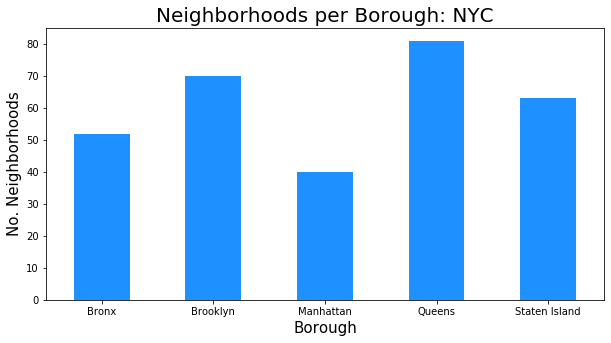

In [11]:
clr = "dodgerblue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

Let's analyse further to see how many Chinese restaurants there are in each neighbourhood, borough and graph these results. 

In [12]:
# queens has most neighborhoods
# prepare neighborhood list that contains chinese resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
chinese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    chinese_resturants=venues[venues['Category']=='Chinese Restaurant']   
    print('(',count,'/',len(ny_data),')','Chinese Resturants in '+Neighborhood+', '+Borough+':'+str(len(chinese_resturants)))
    print(row)
    for resturant_detail in chinese_resturants.values.tolist():
        id, name , category=resturant_detail
        chinese_rest_ny = chinese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

    

( 1 / 306 ) Chinese Resturants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Chinese Resturants in Co-op City, Bronx:1
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Chinese Resturants in Eastchester, Bronx:1
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Chinese Resturants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Chinese Resturants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Chinese Resturants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Chinese Resturants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Chinese Resturants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Chinese Resturants in Norwood, Bronx:0
['Bronx', '

In [13]:
chinese_rest_ny.to_csv('chinese_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare

In [14]:
chinese_rest_ny = pd.read_csv('chinese_rest_ny_tocsv1.csv')
chinese_rest_ny.tail()

,Unnamed: 0,Borough,Neighborhood,ID,Name
182,182,Brooklyn,Homecrest,514645bae4b0238f38bcdbac,Season Restaurant
183,183,Staten Island,Prince's Bay,4bb7d282b35776b0b83dc801,Island Taste
184,184,Bronx,Allerton,4c7dbf7f10916dcba78e2a96,Chef King
185,185,Bronx,Kingsbridge Heights,4d965fd061a3a1cde4989a42,Lucky Star Chinese Restaurant
186,186,Brooklyn,Erasmus,4e10c87122713f7d7bcb9d1d,Kam Man Chinese Food


In [15]:
chinese_rest_ny.shape

(187, 5)

As we continue our data and Japanese restaurant market analysis, we could see that Manhattan has the least number of neighbourhoods, however the highest number of Japanese restaurants in New York. This could be due to its centrality. However Bronx stands out from the all other boroughs with significantly much less number of Japanese restaurant market, with only one restuarant.  

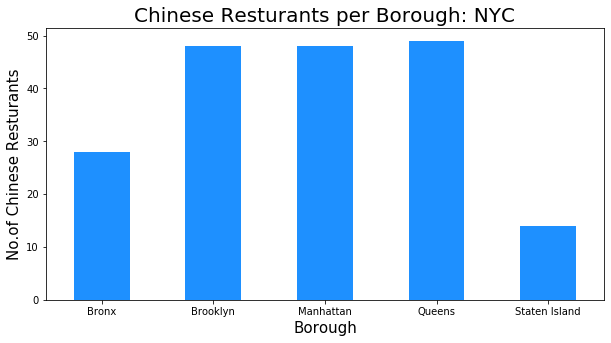

In [16]:
chinese_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = clr)
plt.title('Chinese Resturants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Chinese Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

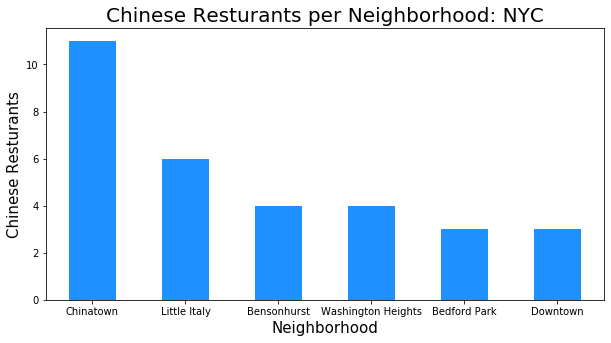

In [17]:
NOofNeigh = 6 # top number for graphing all the same past 6
chinese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Chinese Resturants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Chinese Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [18]:
chinese_rest_ny[chinese_rest_ny['Borough']=='Brooklyn']

,Unnamed: 0,Borough,Neighborhood,ID,Name
23,23,Brooklyn,Bay Ridge,5553702c498ecb85f99d8f37,XIN
24,24,Brooklyn,Bensonhurst,4d9dead0c4b537041abc212e,Tong Xing Chinese & New Taco Mexican Food
25,25,Brooklyn,Bensonhurst,4e4cd93fbd413c4cc66ca721,Great Wall Restaurant
26,26,Brooklyn,Bensonhurst,4bd60f4c4e32d13a6000c280,Taste Of China
27,27,Brooklyn,Bensonhurst,4c2169947e85c928b88aba21,Panda Chinese Restaurant
28,28,Brooklyn,Greenpoint,4abd867df964a520d78a20e3,Shang Hai Lee
29,29,Brooklyn,Manhattan Terrace,4d91f9a1d7b1236a6e343c38,Golden chopsticks
30,30,Brooklyn,East Flatbush,4c6b208e0c3ac9b6be76d138,China Express
31,31,Brooklyn,Windsor Terrace,54e39b14498e9c646b42958e,East Wind Snack Shop
32,32,Brooklyn,Windsor Terrace,4c06e2470e0a2d7fdf8aec0c,#1 Garden Chinese Food


NameError: name 'df_Chinese_Rest_ny' is not defined

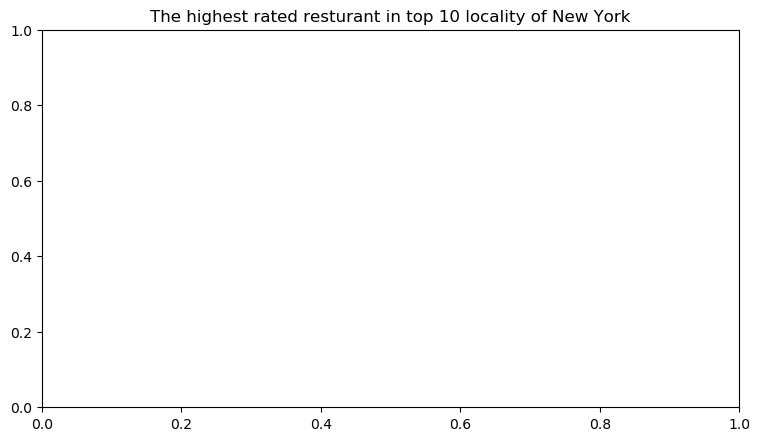

In [20]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('The highest rated resturant in top 10 locality of New York')
#On x-axis

#giving a bar plot
df_Chinese_Rest_ny.groupby('Locality')['Aggregate rating'].mean().nlargest(10).plot(kind='bar')

plt.xlabel('Resturant Locality in New York')
#On y-axis
plt.ylabel('Aggregate Rating')
#displays the plot
plt.show()

In [19]:

for borough, neighborhood, n_id, name in zip(chinese_rest_ny["Borough"], chinese_rest_ny["Neighborhood"], chinese_rest_ny["ID"], chinese_rest_ny["Name"]):
    print(borough, neighborhood, n_id, name)



Bronx Co-op City 4c9d5f2654c8a1cd2e71834b Guang Hui Chinese Restaurant
Bronx Eastchester 4dabc3dc93a04642f09ccabd Xing Lung Chinese Restaurant
Bronx Pelham Parkway 4b9d6b45f964a52078ab36e3 Mr. Q's Chinese Restaurant
Bronx Pelham Parkway 4bc8f646b6c49c74d8898d91 Great Wall Chinese Restaurant
Bronx Bedford Park 4e4d0387bd413c4cc66dfd72 Hung Hing Chinese Restaurant
Bronx Bedford Park 4cba4a550180721ebb739961 Rose Flower Chinese
Bronx Bedford Park 4c87c9930dcb8cfa68e63d68 New Xing Wang Chinese Restaurant
Bronx West Farms 4cd0d4d77b6854810401c4f8 Food Hai
Bronx High  Bridge 4da0c70b7aee5481bda6b2fe wah yong
Bronx Melrose 4dded2c945dd033c3937f203 Hing Wong
Bronx Mott Haven 4df3e68688772e1f81559d14 Good Choice Chinese Restaurant
Bronx Mott Haven 4e31c190b0fbb985a507465a Foo Hing Chinese Restaurant
Bronx Morrisania 4cfece683f846dcb83408d37 Great Wall Chinese Food
Bronx Soundview 4cc63e36bde8f04dcbfeb54b Golden City Chinese Restaurant
Bronx Soundview 4e656e8252b1260c14683b4b Kee Hing Restaurant

In [54]:
 # prepare neighborhood list that contains chinese resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
chinese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in chinese_rest_ny.values.tolist():
    row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except (IndexError, KeyError) as e:
        print('No data available for ID=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    chinese_rest_stats_ny = chinese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

NameError: name 'CLIENT_ID' is not defined

In [23]:
chinese_rest_stats_ny.to_csv('chinese_rest_stats_ny_csv.csv') # I continue to save data to a .csv as I move through this project

In [22]:
chinese_rest_stats_ny.shape



(0, 7)

In [83]:
chinese_rest_stats_ny.info()


<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Borough       0 non-null      object
 1   Neighborhood  0 non-null      object
 2   ID            0 non-null      object
 3   Name          0 non-null      object
 4   Likes         0 non-null      object
 5   Rating        0 non-null      object
 6   Tips          0 non-null      object
dtypes: object(7)
memory usage: 0.0+ bytes


In [ ]:
chinese_rest_stats_ny['Likes']=chinese_rest_stats_ny['Likes'].astype('float64')
chinese_rest_stats_ny['Tips']=chinese_rest_stats_ny['Tips'].astype('float64')
chinese_rest_stats_ny.info()

In [ ]:
chinese_rest_stats_ny.describe()

In [ ]:
# Resturant with maximum Likes
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Likes'].idxmax()]

In [ ]:
# Resturant with maximum Ratings
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Rating'].idxmax()]

In [ ]:
# Resturant with maximum Tips
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Tips'].idxmax()]

In [91]:
ny_neighborhood_stats=chinese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

DataError: No numeric types to aggregate

In [ ]:
ny_borough_stats=italian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()


In [ ]:
italian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5), color=clr)
plt.title('Average rating of Italian Resturants for each Borough', fontsize=20)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

We will visually map the neighborhoods with an average rating greater than or equal to 8 after joining the approprite dfs to include latitudes and longitudes.



In [ ]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

In [ ]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

In [1]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()
# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

NameError: name 'folium' is not defined

In [ ]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

In [ ]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = 'Borough Boundaries.geojson'
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

visualize all NYC buroughs based on average Rating.

In [ ]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'Borough Boundaries.geojson'
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='PuBu', #'YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')